В предыдущей тетрадке я сделал `1d` модель с одной жидкостью. Пора расти, теперь `2d`

In [461]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from math import ceil, floor

In [462]:
nx = 17
ny = 17

k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 1 # m
dy = 5 # m
c = 15.8e-10 # # Pa^-1
phi = 0.4
B = 1
mu = 2.9e-4  # m^2 / s
p_0 = 4e4 * 6894  # psi to Pa
p_1 = 4.1e4 * 6894  # psi to Pa
p_2 = 3.9e4 * 6894  # psi to Pa
d = 3  # m
dt = 1  # s
qw = -0.1 # m3/s

Теперь я поставлю задачу так - в центре есть скважина, в неё течёт $q=\texttt{const}$.

Нужно немного поправить матрицу для лапласиана

In [463]:
lapl = np.zeros((nx*ny, nx*ny))
for dia in range(nx*ny):
    # gonna have 4 neibours
    lapl[dia, dia] = -4 * k * d * dy / dx
    # two neibours on x - axis
    if (int((dia-1) / ny) == int(dia / ny)) & (dia-1 >= 0):
        lapl[dia, dia-1] = k * d * dy / dx
    if (int((dia+1) / ny) == int(dia / ny)) & (dia+1 < nx*ny):
        lapl[dia, dia+1] = k * d * dy / dx
    # two neybours on y axis
    if dia-ny >= 0:
        lapl[dia, dia-ny] = k * d * dy / dx
    if dia+ny < nx*ny:
        lapl[dia, dia+ny] = k * d * dy / dx
lapl *= 1 / (mu * B)

In [464]:
dia = 0
int((dia-1) / ny) == int(dia / ny)

True

А $\vec{\tilde{q}}$ становится намного сложнее

In [465]:
wells_q = {(ceil(nx / 3.)-1, ceil(ny / 3.)-1): -1e-1,
           ((ceil(2 * nx / 3.)-1, ceil(2 * ny / 3.)-1)): -5e-2
          }

In [466]:
# do as 2d matrix and then convert to big vector
q_tilde = np.zeros((nx, ny))
# but let's firstly add well
for well in wells_q:
    q_tilde[well] = wells_q[well]
for col in range(ny):
    q_tilde[0, col] += 1 / (mu * B) * k * dy * d / dx * p_0
    q_tilde[nx-1, col] += 1 / (mu * B) * k * dy * d / dx * p_0

for row in range(nx):
    q_tilde[row, 0] += 1 / (mu * B) * k * dy * d / dx * p_0
    q_tilde[row, ny-1] += 1 / (mu * B) * k * dy * d / dx * p_0
    
q_tilde = q_tilde.reshape((-1, 1))

In [467]:
1 / (mu * B) * k * dy * d / dx * p_0

0.28341471724137934

In [468]:
dt_coeff = dx * dy * d * phi * c / dt

К сожалению, анаилическое решение  этой задаче представить нет возможности

In [469]:
n_iter = int(3e3)
p_ex = np.ones((nx*ny, 1)) * p_0
p_im = np.ones((nx*ny, 1)) * p_0
t = 0
xs = list(np.linspace(0, nx-1, nx) * dx * 1.01)
plot_freq = int(1e1)

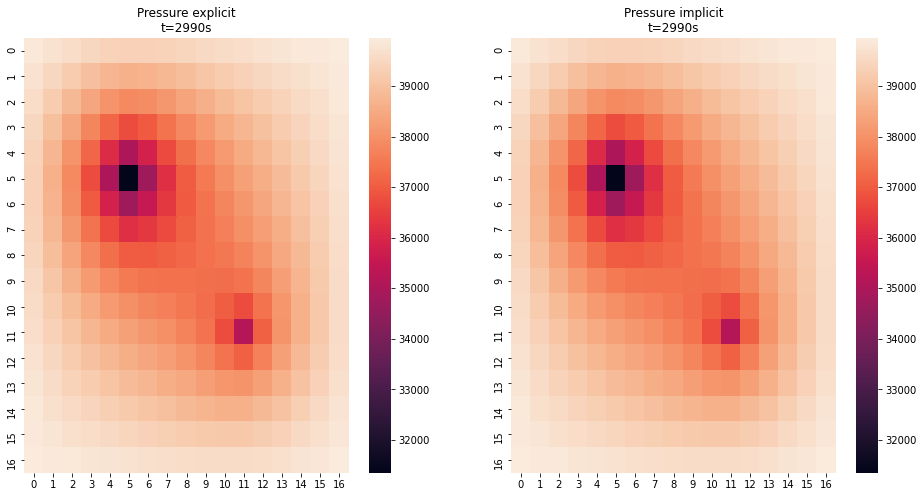

In [470]:
for i in range(1, n_iter):
    # upd pressure
    p_ex += 1 / dt_coeff * (lapl.dot(p_ex) + q_tilde)
    p_im += 1 / dt_coeff * (q_tilde)
    p_im = np.linalg.inv(np.eye(nx*ny) - 1 / dt_coeff * lapl).dot(p_im)
    t += dt
    if i % plot_freq == 0:
    # append some history
    # let's draw
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        g1 = sns.heatmap(p_ex.reshape((nx, ny)) / 6894., ax=ax[0], cbar=True)
        g2 = sns.heatmap(p_im.reshape((nx, ny)) / 6894., ax=ax[1], cbar=True)
        g2.set_title(f'Pressure implicit\nt={t}s')
        g1.set_title(f'Pressure explicit\nt={t}s')
        plt.show()

Быстро, чётко, нормально. Предлагаю вернуться к описанию модели по Джону Форстеру и сделать скважину не постоянного напора, а скважину с постоянным давлением

$$q_{\alpha} = (p_{w} - p_{l}) \cdot \frac{4\pi k_{\alpha}}{B_{\alpha}\mu_{\alpha}} \cdot \frac{r_w r_{ref}}{r_w - r_{ref}}=\\
(p_{w} - p_{l}) \cdot J_l^{\alpha}
$$

$$\vec{p^{n+1}} = \vec{p^{n}} + \frac{1}{\texttt{dt_coeff}} \cdot\Big( \texttt{Lapl} \cdot \vec{p^n} + \vec{\tilde{q}} - J \vec{p} + J \vec{p_w} \Big)
$$

In [471]:
r_w = 0.05
r_ref = 1 / (1 / dx + np.pi / d)
p_w = p_0 - 20 * 6894

In [472]:
wells_p = {((ceil(1 * nx / 3.)-1, ceil(1 * ny / 3.)-1)): p_0 - 20 * 6894,
           ((ceil(2 * nx / 3.)-1, ceil(2 * ny / 3.)-1)): p_0 - 50 * 6894
          }

In [473]:
j = np.zeros((nx, ny))
for well in wells_p:
    j[well] = 4 * np.pi * k / B / mu * r_w * r_ref / (r_w + r_ref)
j = j.reshape(-1)
j = np.diag(j).copy()

In [474]:
p_w_v = np.zeros((nx, ny))

for well in wells_p:
    p_w_v[well] = wells_p[well]
p_w_v = p_w_v.reshape((-1, 1))

In [475]:
# do as 2d matrix and then convert to big vector
q_tilde = np.zeros((nx, ny))
# but let's firstly add well
wx, wy = ceil(nx / 2.)-1, ceil(ny/2.)-1
#q_tilde[wx, wy] = qw
for col in range(ny):
    q_tilde[0, col] += 1 / (mu * B) * k * dy * d / dx * p_0
    q_tilde[nx-1, col] += 1 / (mu * B) * k * dy * d / dx * p_0

for row in range(nx):
    q_tilde[row, 0] += 1 / (mu * B) * k * dy * d / dx * p_0
    q_tilde[row, ny-1] += 1 / (mu * B) * k * dy * d / dx * p_0
    
q_tilde = q_tilde.reshape((-1, 1))

In [476]:
n_iter = int(1.2e3)
p_ex = np.ones((nx*ny, 1)) * p_0
p_im = np.ones((nx*ny, 1)) * p_0
t = 0
xs = list(np.linspace(0, nx-1, nx) * dx * 1.01)
p_w_hist_ex = {}
p_w_hist_im = {}
for well in wells_p:
    p_w_hist_ex[well] = []
    p_w_hist_im[well] = []
ts = []
tot_rate = []
plot_freq = int(1e1)

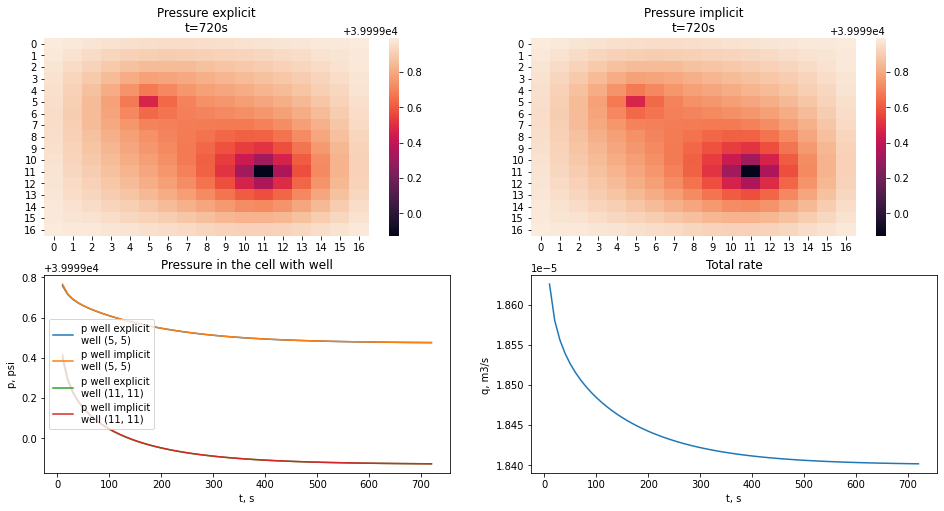

In [ ]:
for i in range(1, n_iter):
    # upd pressure
    p_ex += 1 / dt_coeff * (lapl.dot(p_ex) + q_tilde - j.dot(p_ex) + j.dot(p_w_v))
    p_im += 1 / dt_coeff * (q_tilde + j.dot(p_w_v))
    p_im = np.linalg.inv(np.eye(nx*ny) - 1 / dt_coeff * (lapl - j)).dot(p_im)
    t += dt
    if i % plot_freq == 0:
        ts.append(t)
        for well in wells_p:
            p_w_hist_ex[well].append((p_ex.reshape((nx, ny)) / 6894.)[well])
            p_w_hist_im[well].append((p_im.reshape((nx, ny)) / 6894.)[well])
        tot_rate.append(j.dot(p_im - p_w_v).sum())
        # append some history
        # let's draw
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
        g1 = sns.heatmap(p_ex.reshape((nx, ny)) / 6894., ax=ax[0][0], cbar=True)
        g2 = sns.heatmap(p_im.reshape((nx, ny)) / 6894., ax=ax[0][1], cbar=True)
        g2.set_title(f'Pressure implicit\nt={t}s')
        g1.set_title(f'Pressure explicit\nt={t}s')
        for well in wells_p:
            ax[1][0].plot(ts, p_w_hist_ex[well], label=f'p well explicit\nwell {well}')
            ax[1][0].plot(ts, p_w_hist_im[well], label=f'p well implicit\nwell {well}')
        ax[1][0].set_title('Pressure in the cell with well')
        ax[1][0].set_xlabel(f't, s')
        ax[1][0].set_ylabel(f'p, psi')
        ax[1][0].legend()
        # rate
        ax[1][1].plot(ts,tot_rate)
        ax[1][1].set_title('Total rate')
        ax[1][1].set_xlabel(f't, s')
        ax[1][1].set_ylabel(f'q, m3/s ')
        # ax[1][1].set_ylim(bottom=0)
        plt.show()